#### Ở phần trước, chúng ta đã thử thí nghiệm dự đoán với mô hinh VGG-16 bằng một tấm ảnh hết sức khó nhằn đối với AI cho nên nó đã cho kết quả là "Japanese_spaniel". Đây là một kết quả không mấy chính xác nhưng tuy nhiên đó chỉ là một ví dụ thú vị mà ta muốn thử độ mạnh mẽ của mô hình này mà thôi. Bây giờ chúng ta sẽ cùng xem qua lại kết quả mà ta vừa đã thử nghiệm với ảnh đầu tiên là bức ảnh đầu vào và bức ảnh thứ hai là thể hiện chủng loại mà giống chó mô hình đã dự đoán.

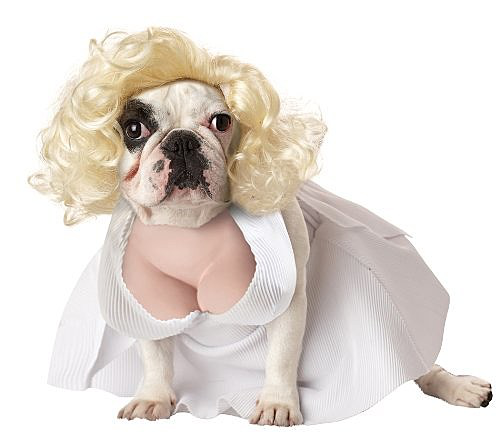

In [1]:
import os.path as osp
from PIL import Image
from IPython.display import display
img_1 = Image.open("./funny_dog.jpg")
display(img_1)

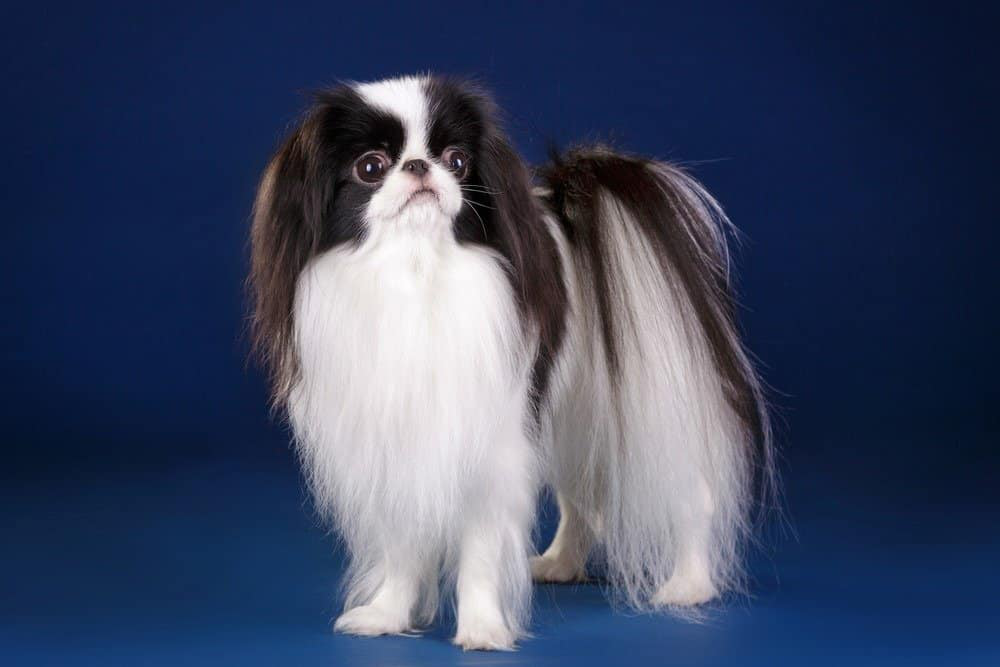

In [2]:
img_2 = Image.open("./japanese-chin-2.jpg")
display(img_2)

#### Đến đây ta cũng có thấy chút tương đồng của hai bức ảnh này rồi ấy chứ nhỉ :v Chắc là tại vì tấm ảnh trên chú chó kia đội thêm tóc giả vàng khiến cho mô hình của chúng ta nhận biết sai. Hôm nay, chúng ta sẽ bắt tay vào đi từ đầu đến cuối việc thực hành Transfer Learning cho tác vụ "Phân loại ong và kiến dựa trên mô hình VGG-16" nha

### Overview data

In [3]:
train_path = "./hymenoptera_data/train/"
val_path = "./hymenoptera_data/val/"
ants_path = "ants"
bees_path = "bees"

In [4]:
import os
train_ants_list = os.listdir(osp.join(train_path, ants_path))
train_bees_list = os.listdir(osp.join(train_path, bees_path))
val_ants_list = os.listdir(osp.join(val_path, ants_path))
val_bees_list = os.listdir(osp.join(val_path, bees_path))
print(f"Length train_ants_list: {len(train_ants_list)} \nLength train_bees_list: {len(train_bees_list)} \nLength val_ants_list: {len(val_ants_list)} \nLength val_bees_list: {len(val_bees_list)}")

Length train_ants_list: 124 
Length train_bees_list: 121 
Length val_ants_list: 70 
Length val_bees_list: 83


### Import library

In [5]:
import random
import glob #thư viện này để hiển thị toàn bộ đường dẫn ảnh thành 1 string
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
%matplotlib inline 
#matplotlib inline để hiển thị ảnh trên notebook đỡ gián đoạn

import torch
import torch.nn as nn
import torchvision #thư viện giúp tiền xử lý ảnh 
import torch.optim as optim # để sử dụng các hàm optimizer có sẵn svg, adam, ...
import torch.utils.data as data #thư viện giúp xử lý data
from torchvision import models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [6]:
torch.manual_seed(42)
np.random.seed(44)
random.seed(56)
# những cái trên là để khi ta ran dom đều cho ra cùng 1 kết quả với mỗi thư viện

### Tiền xử lý ảnh

In [7]:
# Đây là class tiền xử lý ảnh trước khi để nó vào model
class ImageTransfer():
    def __init__(self, resize, mean, std):
        # Tại sao lại có data_transfer là 1 dict với 2 key gồm "train" và "valid"
        # Vì khi train, để mô hình học 1 cách tổng quát ta sẽ lấy đi nhiều hơn các dữ liệu ảnh trong tập trên
        # Tập valid thì chỉ cần đơn giản là thay đổi kích thước cho phù hợp với đầu vào của mô hình và tập trung vào đối tượng
        # Chính vì thế, việc tiền xử lý phải chia làm hai giai đoạn đó là tiền xử lý ảnh tập train và tiền xử lý ảnh tập valid
        self.data_transfer = {
            "train": transforms.Compose([
                transforms.Resize(resize),
                transforms.RandomResizedCrop(resize, scale=(0.5,1.5)),
                transforms.RandomHorizontalFlip(0.7),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            
            "valid": transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase = "train"):
        return self.data_transfer[phase](img)

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
resize = 224

In [9]:
#Viết hàm test thử mô hình
def show_image_transfer(img_path):
    img = Image.open(img_path)
    print("Image Orginal")
    display(img)
    
    # Image Train Transfer
    image_transfer = ImageTransfer(resize,mean,std)
    img_train_transfer = image_transfer(img,"train")
    print("Image Train Transfer")
    display(transforms.ToPILImage()(torch.clamp(img_train_transfer,0,1)))
    
    # Image Valid Transfer
    img_valid_transfer = image_transfer(img,"valid")
    print("Image Valid Transfer")
    display(transforms.ToPILImage()(torch.clamp(img_valid_transfer,0,1)))

In [10]:
img_path = "./hymenoptera_data/train/bees/1232245714_f862fbe385.jpg" #lấy bừa 1 ảnh trong folder hymenoptera_data

Image Orginal


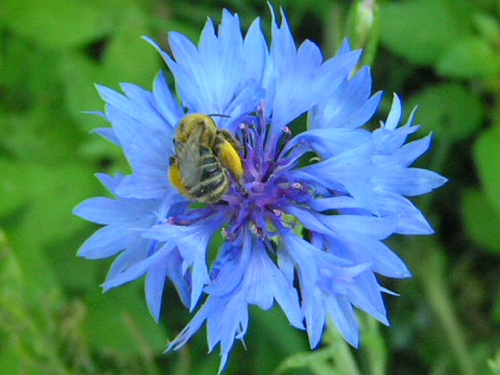

Image Train Transfer


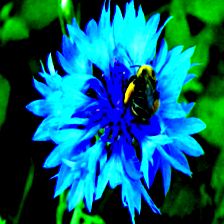

Image Valid Transfer


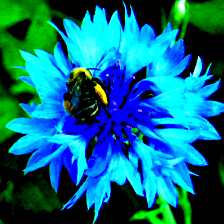

In [11]:
show_image_transfer(img_path=img_path)

Sau khi đã có class tiền xử lý ảnh, chúng ta sẽ cần phải tạo ra một cái gọi là CustomDataSet và sẽ đi tìm hiểu câu hỏi "Tại sao phải tạo CustomDataSet trong khi chúng ta đã có folder hymenoptera_data ở trên có ảnh rồi mà?" :))). Lý giải điều này, tôi sẽ liệt kê một số ý như sau:
- Thực chất folder hymenoptera_data chính là dataset của chúng ta nhưng đó là toàn bộ tập dữ liệu các ảnh thô
- Như ngày xưa hay làm việc với thư viện sklearn để train model chúng ta thường quen mắt với X_train, y_train, X_test, y_test. Thì bây giờ cũng thế, chúng ta phải biến đổi dữ liệu ảnh kia thành dạng dataset như kia nên tôi gọi nó là CustomDataSet.
- Mục tiêu của CustomDataSet đó là biến đổi dữ liệu ảnh thực tế kia thành các tập dữ liệu X_train, y_train, X_valid, y_valid và bên trong các tập dữ liệu đó thực chất là các tensor của bức ảnh được số hóa (tập X) và nhãn của bức ảnh đó (tập y)

### Lấy danh sách đường dẫn ảnh

Ủa, tại sao bên trên bảo tạo CustomDataSet, dưới đây lại "Lấy danh sách đường dẫn ảnh" làm chi ba :)), à thực ra mình làm là có mục đích cả đó và mình sẽ liệt kê một số ý dưới đây:
- Như các bạn biết, đường dẫn ảnh của chúng ta sẽ có dạng "./hymenoptera_data/\<train or val\>/\<bees or ants\>/\<image.jpg\>". Mấu chốt là ở chỗ "train or val" và "bees or ants" kia kìa...
- Những cái đấy, sẽ vừa giúp chúng ta xác định được dữ liệu để train hay dữ liệu để valid và đó là ảnh con ong (bees) hay con kiến (ants)
- Đến đây bạn đã hiểu vì sao phải lấy ra danh sách đường dẫn ảnh chưa ^^, để từ đường dẫn đó ta biết đường mà tách và xác định dữ liệu mình đang thực hiện là loại và như thế nào

In [12]:
def get_list_dir():
    train_path_list = list([])
    valid_path_list = list([])
    other_path_list = list([])
    root_path = "./hymenoptera_data/*/*/*.jpg"
    path_list = glob.glob(root_path)
    for path in path_list:
        tmp_dict=dict({"dataset":"",
                      "classes":"",
                      "img_id":""})
        if path[19] == "t":
            tmp_dict['dataset'] = path[19:24]
            tmp_dict['classes'] = path[25:29]
            tmp_dict['img_id'] = path[30:]
        elif path[19] == "v":
            tmp_dict['dataset'] = path[19:22]
            tmp_dict['classes'] = path[23:27]
            tmp_dict['img_id'] = path[28:]
        if tmp_dict['dataset'] =="train":
            train_path_list.append(tmp_dict)
        elif tmp_dict['dataset'] == "val":
            valid_path_list.append(tmp_dict)
        else:
            other_path_list.append(tmp_dict)
    return train_path_list,valid_path_list,other_path_list

In [13]:
train_path_list, valid_path_list,other_path_list = get_list_dir()
train_path_list

[{'dataset': 'train', 'classes': 'ants', 'img_id': '0013035.jpg'},
 {'dataset': 'train',
  'classes': 'ants',
  'img_id': '1030023514_aad5c608f9.jpg'},
 {'dataset': 'train',
  'classes': 'ants',
  'img_id': '1095476100_3906d8afde.jpg'},
 {'dataset': 'train',
  'classes': 'ants',
  'img_id': '1099452230_d1949d3250.jpg'},
 {'dataset': 'train', 'classes': 'ants', 'img_id': '116570827_e9c126745d.jpg'},
 {'dataset': 'train',
  'classes': 'ants',
  'img_id': '1225872729_6f0856588f.jpg'},
 {'dataset': 'train',
  'classes': 'ants',
  'img_id': '1262877379_64fcada201.jpg'},
 {'dataset': 'train',
  'classes': 'ants',
  'img_id': '1269756697_0bce92cdab.jpg'},
 {'dataset': 'train',
  'classes': 'ants',
  'img_id': '1286984635_5119e80de1.jpg'},
 {'dataset': 'train', 'classes': 'ants', 'img_id': '132478121_2a430adea2.jpg'},
 {'dataset': 'train',
  'classes': 'ants',
  'img_id': '1360291657_dc248c5eea.jpg'},
 {'dataset': 'train',
  'classes': 'ants',
  'img_id': '1368913450_e146e2fb6d.jpg'},
 {'datas

In [14]:
valid_path_list

[{'dataset': 'val', 'classes': 'ants', 'img_id': '10308379_1b6c72e180.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '1053149811_f62a3410d3.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '1073564163_225a64f170.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '1119630822_cd325ea21a.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '1124525276_816a07c17f.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '11381045_b352a47d8c.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '119785936_dd428e40c3.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '1247887232_edcb61246c.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '1262751255_c56c042b7b.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '1337725712_2eb53cd742.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '1358854066_5ad8015f7f.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '1440002809_b268d9a66a.jpg'},
 {'dataset': 'val', 'classes': 'ants', 'img_id': '1475422

In [15]:
other_path_list

[]

Vậy là chúng ta đã tạo xong hàm ghi lại tất cả các đường dẫn của các tấm ảnh kia rồi

### Tạo CustomDataSet

In [16]:
class CustomDataSet():
    def __init__(self, path_list, transform = None, phase ="train"):
        self.path_list = path_list
        self.transform = transform
        self.phase=phase
    def __len__(self):
        return len(self.path_list)
    def __getitem__(self,index):
        img_path = "./hymenoptera_data/" + self.path_list[index]["dataset"]+"/"+self.path_list[index]["classes"]+"/"+self.path_list[index]["img_id"]
        label = self.path_list[index]["classes"]
        if label =="ants":
            label = 1
        elif label =="bees":
            label = 0
        img = Image.open(img_path)
        img_train_transfer = self.transform(img,phase=self.phase)
        return img_train_transfer,label

In [17]:
train_dataset= CustomDataSet(train_path_list, transform=ImageTransfer(resize,mean,std),phase="train")
valid_dataset= CustomDataSet(valid_path_list, transform=ImageTransfer(resize,mean,std),phase="valid")

In [18]:
train_dataloader = DataLoader(train_dataset,batch_size=2,shuffle=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=2,shuffle=False)

In [19]:
batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(f'{inputs.size()} {label}')

torch.Size([2, 3, 224, 224]) tensor([0, 1])


Như vậy, chúng ta đã đi vào và tạo xong DataSet cũng như DataLoader. Nói lại một chút về 2 khái niệm này trước khi chuyển sang xây dựng network.
- DataSet thực chất là việc biến đổi các item trong tập dữ liệu sang dạng tensor chuẩn nhất
- Dataloader thì giúp việc chia batch-size trở nên dễ dàng bằng cách truyền DataSet vào. Nó sẽ tự sinh ra một mảng với các batchsize được chia.

### Network

Thực ra ở nội dung này, chúng ta là transfer learning cho nên cơ bản vẫn là sử dụng lại mô hình VGG-16 thôi chứ không phải xây dựng gì to tát cả. Điều đặc biệt ở đây, là vì bài toán của ta chỉ phân loại 2 nhãn (ong và kiến) cho nên ta cần thay đổi layer cuối của mô hình => Việc thay đổi mỗi layer cuối này ngta gọi là transfer learning

In [20]:
vgg16 = models.vgg16(pretrained = True)
vgg16

C:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Được rồi, chúng ta đã lấy ra mô hình VGG-16 có sẵn trên thư viện pytorch. Chúng ta có thể xem lại cấu trúc mô hình của VGG-16 cho nhớ nhưng mục tiêu trong dự án này chủ yếu sẽ chỉ thay đổi layer cuối cùng từ 1000  thành 2 đầu ra mà thôi :v (Có mỗi 2 class ong và kiến thì 1000 đầu ra làm chi ba) :3

In [21]:
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2,bias=True)
vgg16
vgg16.train() #khi sử dụng mô hình có sẵn mình phải nhắc xem mình sử dụng nó làm gì thì PyTorch mới biết => Cái này gọi là set mode
#Nếu set mode = train() thì ta sẽ sử dụng để train mô hình và nó sẽ enable cho mình các tham số và giữ lại gradient để backward
#Nếu set mode = eval() thì ta sử dụng đơn giản chỉ để đánh giá kết quả thôi, nó không giữ lại gradient để backward

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Đoạn code trên là xong việc transfer learning rồi đấy, chính ra làm AI cũng dễ nhỉ :v Haha đùa thôi, còn phía sau nữa mà...

### Loss function

Ở đây chúng ta sẽ phải sử dụng hàm loss function để mạng network (bên trên) đánh giá kết quả đúng sai nhiều không mà còn biết đường backward cho hợp lý. Kiến thức này liên quan đến việc hiệu chỉnh các tham số weigh để mô hình phán đoán tốt hơn...

In [22]:
criterior = nn.CrossEntropyLoss()

### Optimizer

Hàm tối ưu ư... cái này để đưa ra tốc độ tối ưu hàm mất mát về giá trị nhỏ nhất, bao gồm SGD, learning rate trong đó:
- SGD là Stochastic Gradient Descent thể hiện cách học dựa trên một điểm dữ liệu
- learning rate là tốc độ học...
- Đối với các parameters ở bài này, chúng ta chỉ muốn cập nhật một vài các thay đổi ở layer cuối thì phải thực hiện thêm...

In [23]:
params_to_update = [] # để list rỗng để tí lưu lại các parameters trong layer cuối
update_param_names = ["classifier.6.weight", "classifier.6.bias"] #tên những papram (weight, bias) cần phải cập nhật tại classifier (6)
for name,param in vgg16.named_parameters(): 
#vgg16.named_parameters() sẽ hiển thị tên(key) và giá trị của từng layer với các tham số trong đó
# name: tên layer đó, ví dụ như hình dưới features.0.weight
# param: cấu hình của tensor layer đó (Batch, Chanel, Heigh, Width)
    print(f'{name} - {param.size()}')
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False

features.0.weight - torch.Size([64, 3, 3, 3])
features.0.bias - torch.Size([64])
features.2.weight - torch.Size([64, 64, 3, 3])
features.2.bias - torch.Size([64])
features.5.weight - torch.Size([128, 64, 3, 3])
features.5.bias - torch.Size([128])
features.7.weight - torch.Size([128, 128, 3, 3])
features.7.bias - torch.Size([128])
features.10.weight - torch.Size([256, 128, 3, 3])
features.10.bias - torch.Size([256])
features.12.weight - torch.Size([256, 256, 3, 3])
features.12.bias - torch.Size([256])
features.14.weight - torch.Size([256, 256, 3, 3])
features.14.bias - torch.Size([256])
features.17.weight - torch.Size([512, 256, 3, 3])
features.17.bias - torch.Size([512])
features.19.weight - torch.Size([512, 512, 3, 3])
features.19.bias - torch.Size([512])
features.21.weight - torch.Size([512, 512, 3, 3])
features.21.bias - torch.Size([512])
features.24.weight - torch.Size([512, 512, 3, 3])
features.24.bias - torch.Size([512])
features.26.weight - torch.Size([512, 512, 3, 3])
features.

In [24]:
params_to_update

[Parameter containing:
 tensor([[-0.0137, -0.0132,  0.0079,  ..., -0.0082, -0.0082, -0.0065],
         [-0.0094,  0.0030,  0.0124,  ...,  0.0099, -0.0055,  0.0025]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0078, -0.0007], requires_grad=True)]

In [25]:
optimizer = optim.SGD(params=params_to_update,lr=0.001,momentum=0.9)

Như vậy chúng ta đã di qua các phần liên quan đến network, loss function, optimizer và cần thay đổi cũng như cho mô hình biết trọng số nào cần được cập nhật. Tiếp theo, chúng ta sẽ đi tiếp vào module train để tiến hành train và thực nghiệm mô hình

### Train model

In [26]:
dataloader_dict = {"train":train_dataloader,"valid":valid_dataloader}
len(dataloader_dict["train"].dataset)

243

In [27]:
def train_model(net,dataloader, criterior, optimizer, epochs):
    train_loss_arr=[]
    valid_loss_arr=[]
    
    train_acc_arr=[]
    valid_acc_arr=[]
    for epoch in range(epochs): # mỗi 1 epoch là việc tạo đạo hàm và backpropagation hết tất cả các điểm dữ liệu ở dataloader
        print(f'Epoch {epoch+1} / {epochs}')
        for process in ["train", "valid"]:
            acc = 0.0
            loss = 0.0
            if process == "train":
                net.train()
                print("Phase TRAIN")
                for input_target,label_target in tqdm(dataloader[process]):
                    optimizer.zero_grad()
                    label_pred = net(input_target)
                    oup = criterior(label_pred,label_target)
                    oup.backward()
                    _, pred = torch.max(label_pred,1)
                    acc+= torch.sum(pred==label_target.data)
                    loss+= oup.item() * input_target.size(0)
                    optimizer.step()
            elif process == "valid":
                net.eval()
                print("Phase VALID")
                for input_target,label_target in tqdm(dataloader[process]):
                    label_pred = net(input_target)
                    oup = criterior(label_pred,label_target)
                    _, pred = torch.max(label_pred,1)
                    acc+= torch.sum(pred==label_target.data)
                    loss+= oup.item() * input_target.size(0)
            
            acc = acc/len(dataloader[process].dataset)
            loss = loss / len(dataloader[process].dataset)
            if(process=="train"):
                train_loss_arr.append(loss)
                train_acc_arr.append(acc)
            else:
                valid_loss_arr.append(loss)
                valid_acc_arr.append(acc)
            print(f'{process} >> Loss: {loss} | Accuracy: {acc}')
    return train_acc_arr, train_loss_arr, valid_acc_arr, valid_loss_arr    

In [28]:
epochs = 1
train_acc_arr, train_loss_arr, valid_acc_arr, valid_loss_arr = train_model(net=vgg16,dataloader=dataloader_dict,criterior=criterior, optimizer=optimizer,epochs=epochs)

Epoch 1 / 1
Phase TRAIN
train >> Loss: 0.4162385231883445 | Accuracy: 0.8765432238578796
Phase VALID
valid >> Loss: 0.18695729316124168 | Accuracy: 0.9411764740943909


In [29]:
train_acc_arr

[tensor(0.8765)]

Như vậy là bên trên là toàn bộ code cho chương trình transfers learning để dự đoán 2 bức ảnh ong và kiến. Bài tập đến đây là kết thúc nha